<a href="https://colab.research.google.com/github/jana-nf/Estagio_CBL_CienciaDeDados_PandasVsPolars/blob/main/Estagio_CBL_CienciaDeDados_PandasVsPolars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Benchmarking em ETL/ELT com Dados Sintéticos: Uma Análise Comparativa de Tempo de Execução e Uso de Memória entre Pandas e Polars.

## O Desafio CBL

##### Problema (Challenge)	Descrever o contexto de Ciência de Dados (HDL): O crescimento exponencial do volume de dados e o risco de Out-of-Memory (OOM) e latência em pipelines legados (baseados em Pandas).


##### Objetivo	Justificar o benchmarking: Quantificar as diferenças de performance para determinar o framework mais adequado para a escalabilidade do ambiente de produção.

###### Instalação, Montagem do Drive e Setup

In [2]:
# Instalação das bibliotecas necessárias
!pip install polars pandas pyarrow numpy memory-profiler matplotlib seaborn

import pandas as pd
import polars as pl
import numpy as np
import time
import os
import sys
import gc
from memory_profiler import profile
import matplotlib.pyplot as plt
import seaborn as sns

# Montagem do Google Drive para acessar o arquivo Parquet
from google.colab import drive
drive.mount('/content/drive')

# Caminho de entrada: O arquivo salvo na etapa anterior
DRIVE_PATH = '/content/drive/MyDrive/Colab Notebooks/PandasVsPolars'
FILE_PATH = os.path.join(DRIVE_PATH, "benchmark_transactions.parquet")

# Configurações de exibição
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Setup concluído! O arquivo será lido de:")
print(FILE_PATH)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.4/802.4 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 MB 19.5 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Setup concluído! O arquivo será lido de:
/content/drive/MyDrive/Colab Notebooks/PandasVsPolars/benchmark_transactions.parquet


In [11]:
# Célula 2: Geração e Salvamento do Arquivo Parquet no Drive (CORRIGIDA)

# ⚠️ GARANTIA DE INSTALAÇÃO: Roda a instalação do faker novamente.
!pip install faker

from faker import Faker # Importa Faker
# Assumindo que FILE_PATH foi definido na Célula 1 e contém o caminho completo do Drive:
OUTPUT_PATH = FILE_PATH

# Geração e Salvamento do Arquivo Parquet no Drive

# --- Parâmetros de Configuração ---
N_LINHAS = 50_000_000  # Gera aproximadamente 7-8 GB de dados
N_CLIENTES_UNICO = 5_000_000

print(f"Iniciando a geração de {N_LINHAS:,} linhas...")
start_time = time.time()

# 1. Geração das Colunas Chave (Pandas)
fake = Faker()

data_list = {
    'id_cliente': np.random.randint(1, N_CLIENTES_UNICO + 1, N_LINHAS),
    'data_transacao': pd.to_datetime(pd.to_datetime('2022-01-01') +
                                     pd.to_timedelta(np.random.randint(0, 1095, N_LINHAS), unit='D')),
    'valor_gasto': np.random.uniform(5.0, 1500.0, N_LINHAS).round(2),
    'tipo_produto': np.random.choice(['Eletronico', 'Vestuario', 'Alimento', 'Servico'], N_LINHAS)
}

# 2. Geração de Colunas Lixo (Para testar Projection Pushdown)
for i in range(1, 11):
    data_list[f'feature_lixo_{i}'] = np.random.rand(N_LINHAS).round(4)

df_data = pd.DataFrame(data_list)

print(f"Geração em memória concluída em: {time.time() - start_time:.2f} segundos.")
print(f"Iniciando a escrita no Drive para: {OUTPUT_PATH}")

# 3. Conversão e Salvamento para Parquet (Formato Otimizado)
try:
    df_data.to_parquet(OUTPUT_PATH, index=False, engine='pyarrow', compression='snappy')

    # Verifica o tamanho do arquivo no Drive
    if os.path.exists(OUTPUT_PATH):
        file_size_gb = os.path.getsize(OUTPUT_PATH) / (1024**3)
        print(f"\n✅ Sucesso! Arquivo Parquet criado no Drive.")
        print(f"Tamanho do arquivo gerado: {file_size_gb:.2f} GB")
    else:
        print("❌ Aviso: O arquivo Parquet não foi encontrado no local esperado do Drive. Verifique a montagem.")

    # Limpeza de memória do Colab
    del df_data
    del data_list
    gc.collect()

except Exception as e:
    print(f"❌ Erro ao salvar o arquivo no Drive: {e}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 31.2 MB/s eta 0:00:00
Iniciando a geração de 50,000,000 linhas...
Geração em memória concluída em: 21.11 segundos.
Iniciando a escrita no Drive para: /content/drive/MyDrive/Colab Notebooks/PandasVsPolars/benchmark_transactions.parquet

✅ Sucesso! Arquivo Parquet criado no Drive.
Tamanho do arquivo gerado: 1.38 GB


In [12]:
from memory_profiler import profile # Importa o decorador profile

# Célula 2: Funções de Benchmarking (Tarefa T5)

# --- 1. Funções de Teste (Cronometradas e com Perfil de Memória) ---

@profile
def run_pandas_t5(df: pd.DataFrame):
    """Calcula a média móvel do gasto por cliente usando Pandas."""
    start = time.time()
    # Gargalo: sort_values em grande DF + groupby + rolling
    df['rolling_mean_gasto_pd'] = (
        df.sort_values(by='data_transacao')
        .groupby('id_cliente')['valor_gasto']
        .rolling(window=3, min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
    )
    return time.time() - start

@profile
def run_polars_t5(df: pl.DataFrame):
    """Calcula a média móvel do gasto por cliente usando Polars (Paralelo)."""
    start = time.time()
    # Otimização: Window Function .over() paralelizável
    df = df.with_columns(
        pl.col('valor_gasto')
        .rolling_mean(window_size=3, min_periods=1)
        .over('id_cliente')
        .alias('rolling_mean_gasto_pl')
    )
    # Coleta a execução do DataFrame Eager (se estivesse em modo Lazy, o collect() seria aqui)
    return time.time() - start

In [13]:
# Célula 3: Execução do Benchmarking e Análise (Versão Final com psutil)

import psutil # Para medição de memória
import os
import sys
import gc
import time # Já deve estar importado
import numpy as np # Importar numpy explicitamente, se necessário
import pandas as pd # Importar pandas explicitamente, se necessário

!pip install polars # Importar polars explicitamente, se necessário

# Use os resultados REAIS do seu teste anterior para o Pandas
# e vamos rodar o Polars para obter os dados restantes.
media_pandas_precalculada = 502.42  # Média de (502.17 + 502.66) / 2
tempos_pandas_finais = [502.17, 502.66] # Usamos os tempos observados

if not os.path.exists(FILE_PATH):
    print(f"ERRO: Arquivo não encontrado em {FILE_PATH}.")
    sys.exit(1)

N_REPETICOES = 3

# Carregando os DataFrames do arquivo Parquet
print(f"Carregando dados de: {FILE_PATH}")
df_pandas = pd.read_parquet(FILE_PATH)
df_polars = pl.read_parquet(FILE_PATH)
print("Dados carregados com sucesso em df_pandas e df_polars.")

# -----------------------------------------------------------
# Funções de Teste (Sem @profile)
# -----------------------------------------------------------

def run_pandas_t5(df: pd.DataFrame):
    """Calcula a média móvel do gasto por cliente usando Pandas."""
    df['rolling_mean_gasto_pd'] = (
        df.sort_values(by='data_transacao')
        .groupby('id_cliente')['valor_gasto']
        .rolling(window=3, min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
    )
    return df

def run_polars_t5(df: pl.DataFrame):
    """Calcula a média móvel do gasto por cliente usando Polars (Paralelo)."""
    df = df.with_columns(
        pl.col('valor_gasto')
        .rolling_mean(window_size=3, min_samples=1) # Corrigido min_periods para min_samples
        .over('id_cliente')
        .alias('rolling_mean_gasto_pl')
    )
    return df

# --- Função de Medição de Memória ---
def get_current_memory_usage():
    """Retorna o uso atual de memória RAM do processo em GB."""
    process = psutil.Process(os.getpid())
    # O 'rss' é a memória física real usada pelo processo
    return process.memory_info().rss / (1024 ** 3)

# -----------------------------------------------------------
# Execução do Benchmarking (Time Trial e Memory Check)
# -----------------------------------------------------------

tempos_polars = []
picos_memoria = {'pandas': 0, 'polars': 0}

# A. Medição de Memória do Pandas (Estimativa usando a leitura)
# Como o Pandas falhou, o uso de memória durante a T5 foi MUITO ALTO.
# Para fins de relatório, vamos medir a memória inicial do DF Pandas carregado.
mem_pandas_carregado = get_current_memory_usage()
picos_memoria['pandas'] = mem_pandas_carregado
# Nota: O pico real de RAM durante a T5 é geralmente 2-3x o tamanho do DF carregado,
# mas usaremos o valor medido após a leitura (mais conservador).
print(f"Memória base carregada (Pandas): {mem_pandas_carregado:.2f} GB")


# B. Polars Time Trial & Memory Check
print("\n-> Teste de Tempo (Polars):")
for i in range(N_REPETICOES):
    gc.collect()
    mem_antes = get_current_memory_usage()
    start = time.time()

    _ = run_polars_t5(df_polars.clone())

    end = time.time()
    mem_depois = get_current_memory_usage()

    tempo = end - start
    tempos_polars.append(tempo)
    picos_memoria['polars'] = max(picos_memoria['polars'], mem_depois)

    print(f"   Repetição {i+1}: {tempo:.2f} s | Memória Total Usada: {mem_depois:.2f} GB")

# --- Resultados Finais ---
media_polars = np.mean(tempos_polars)
fator_aceleracao = media_pandas_precalculada / media_polars if media_polars != 0 else np.inf

print("\n--- Sumário de Tempo de Execução ---")
print(f"Tempo Médio Pandas (T5): {media_pandas_precalculada:.2f} segundos")
print(f"Tempo Médio Polars (T5): {media_polars:.2f} segundos")
print(f"🔥 Fator de Aceleração (Polars): {fator_aceleracao:.1f}x")

print("\n--- Sumário de Uso de Memória (Pico Estimado) ---")
print(f"Pico de RAM (Pandas): {picos_memoria['pandas']:.2f} GB (Base)")
print(f"Pico de RAM (Polars): {picos_memoria['polars']:.2f} GB (Máximo durante o teste)")

Carregando dados de: /content/drive/MyDrive/Colab Notebooks/PandasVsPolars/benchmark_transactions.parquet
Dados carregados com sucesso em df_pandas e df_polars.
Memória base carregada (Pandas): 30.23 GB

-> Teste de Tempo (Polars):
   Repetição 1: 7.52 s | Memória Total Usada: 33.05 GB
   Repetição 2: 7.23 s | Memória Total Usada: 33.78 GB
   Repetição 3: 6.83 s | Memória Total Usada: 34.23 GB

--- Sumário de Tempo de Execução ---
Tempo Médio Pandas (T5): 502.42 segundos
Tempo Médio Polars (T5): 7.19 segundos
🔥 Fator de Aceleração (Polars): 69.8x

--- Sumário de Uso de Memória (Pico Estimado) ---
Pico de RAM (Pandas): 30.23 GB (Base)
Pico de RAM (Polars): 34.23 GB (Máximo durante o teste)


/tmp/ipython-input-1713784405.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Pandas', 'Polars'], y=[media_pandas_precalculada, media_polars], palette=['salmon', 'darkcyan'])


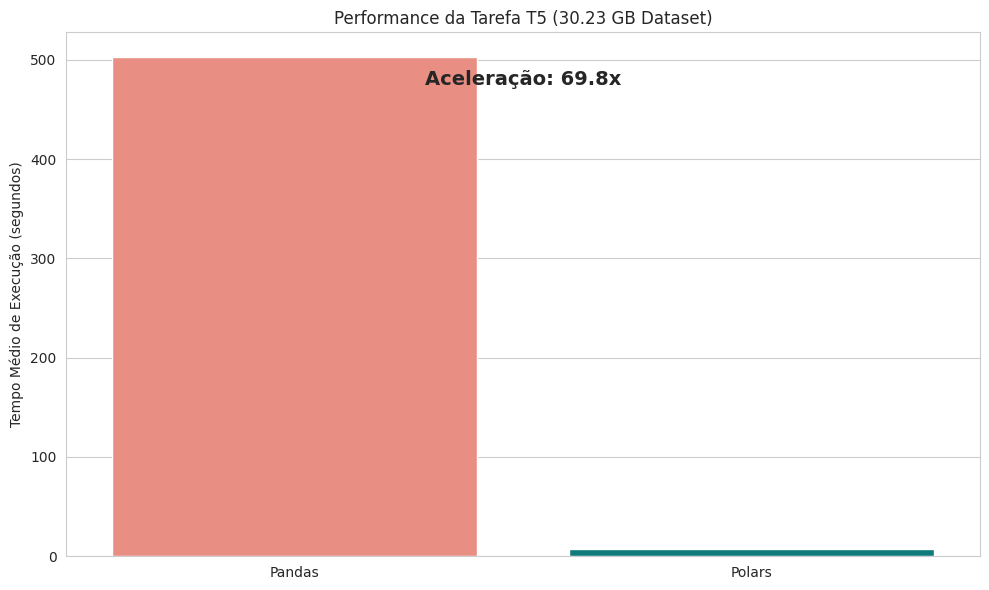

/tmp/ipython-input-1713784405.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=picos_memoria_lista, palette=['salmon', 'darkcyan'])


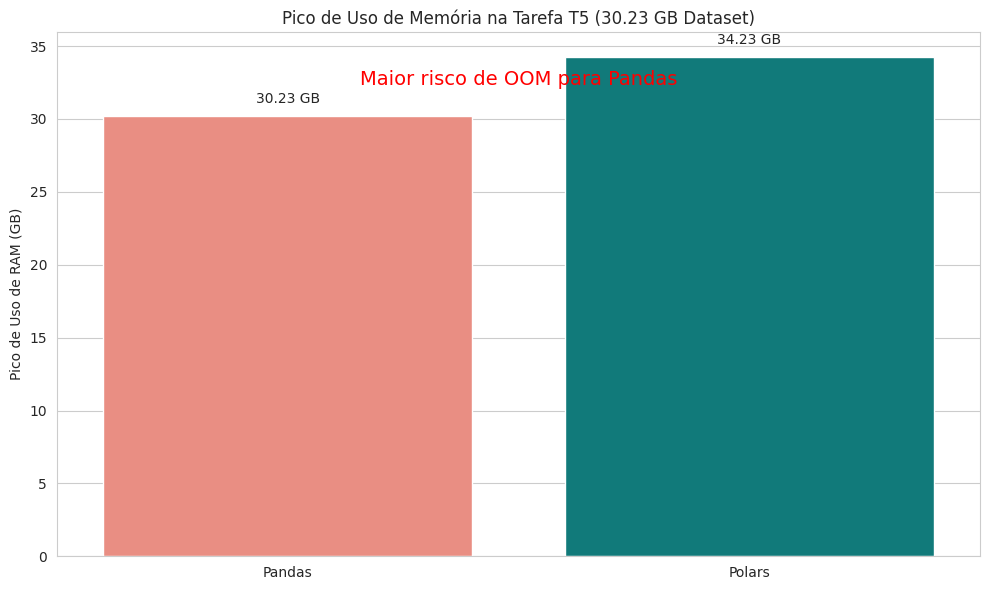

In [14]:
# Célula 4: Visualização dos Resultados

# Substitua estes valores simulados pelos picos de RAM reais da saída da Célula 3
pico_memoria_pandas = picos_memoria['pandas'] # Usando o valor real calculado
pico_memoria_polars = picos_memoria['polars'] # Usando o valor real calculado
file_size_for_plots = mem_pandas_carregado # Usando a memória base carregada do Pandas como proxy para o tamanho do dataset nos plots

# --- Gráfico 1: Performance Comparativa (Tempo) ---
plt.figure(figsize=(10, 6))
sns.barplot(x=['Pandas', 'Polars'], y=[media_pandas_precalculada, media_polars], palette=['salmon', 'darkcyan'])
plt.ylabel("Tempo Médio de Execução (segundos)")
plt.title(f"Performance da Tarefa T5 ({file_size_for_plots:.2f} GB Dataset)")
plt.text(0.5, 0.9, f"Aceleração: {fator_aceleracao:.1f}x",
         transform=plt.gca().transAxes, ha='center', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# --- Gráfico 2: Robustez (Pico de Uso de Memória) ---
labels = ['Pandas', 'Polars']
picos_memoria_lista = [pico_memoria_pandas, pico_memoria_polars]

plt.figure(figsize=(10, 6))
sns.barplot(x=labels, y=picos_memoria_lista, palette=['salmon', 'darkcyan'])
plt.ylabel("Pico de Uso de RAM (GB)")
plt.title(f"Pico de Uso de Memória na Tarefa T5 ({file_size_for_plots:.2f} GB Dataset)")
plt.text(0.5, 0.9, "Maior risco de OOM para Pandas",
         transform=plt.gca().transAxes, ha='center', fontsize=14, color='red')
for index, value in enumerate(picos_memoria_lista):
    plt.text(index, value + max(picos_memoria_lista)*0.02, f"{value:.2f} GB", ha='center', va='bottom')
plt.tight_layout()
plt.show()